1. <u>Imports and downloads</u>

In [ ]:
#!pip install mido
#!pip install midi2audio
#!pip install google-cloud-storage
#!apt-get install -y fluidsynth

In [ ]:
# Imports

# Calc
import numpy as np
import random
import pickle

# Audio
from mido import MidiFile, MidiTrack, Message
from midi2audio import FluidSynth
import librosa
import pygame
import mido

# Image
from PIL import Image

# Visualisation
import matplotlib.pyplot as plt

# Cloud
from io import BytesIO
from google.colab import auth
from google.cloud import storage

# File management
import os
import tempfile

In [ ]:
# Cloud authentification

auth.authenticate_user()
client = storage.Client()
bucket = client.get_bucket('piano-transcription')

In [ ]:
# Useful directories & paths

soundfont_path = 'soundfont/FluidR3_GM.sf2'
midi_directory = 'midi'
wav_directory = 'wav'
spectrograms_directory = 'spectrograms'

<u>2. Useful functions</u>

In [ ]:
# Manage file storage on GCS

def save_pkl_to_gcp(data_list, destination_blob):
    """
    Save a a .pkl file to GCS.
    """

    pkl_list = pickle.dumps(data_list)
    blob = bucket.blob(destination_blob)
    blob.upload_from_string(pkl_list, content_type = 'application/octet-stream')

    print(f"File {destination_blob} uploaded to GCS.")
    return None

def load_pkl_from_gcp(source_blob):
    """
    Load a .pkl file stored in GCS.
    """

    blob = bucket.blob(source_blob)
    pkl_data = blob.download_as_string()
    data_list = pickle.loads(pkl_data)

    print(f"File {source_blob} loaded from GCS.")
    return data_list

def download_blob_to_temp_file(blob_name):
    """
    Download a file from GCS to a local temp file.
    """
    with tempfile.NamedTemporaryFile(delete = False) as temp_file:
        blob = bucket.blob(blob_name)
        blob.download_to_filename(temp_file.name)
    return temp_file.name

def upload_file_to_bucket(local_file_path, blob_name):
    """
    Upload a local file to GCS.
    """
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(local_file_path)

In [ ]:
# From midi (.mid) to audio (.wav)

def convert_midi_to_wav(midi_directory = midi_directory, wav_directory = wav_directory, soundfont_path = soundfont_path):

    """
    Convert an midi file (.mid) into an audio file (.wav)
    """

    soundfont_local_path = download_blob_to_temp_file(soundfont_path)
    fs = FluidSynth(soundfont_local_path)

    midi_blobs = sorted([blob.name for blob in bucket.list_blobs(prefix = midi_directory) if blob.name.endswith('.mid')])

    for midi_blob in midi_blobs:

        midi_local_path = download_blob_to_temp_file(midi_blob)
        wav_blob_name = midi_blob.replace(midi_directory, wav_directory).replace('.mid', '.wav')

        with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as wav_temp_file:
            wav_local_path = wav_temp_file.name
            fs.midi_to_audio(midi_local_path, wav_local_path)

        upload_file_to_bucket(wav_local_path, wav_blob_name)

        os.remove(midi_local_path)
        os.remove(wav_local_path)

    os.remove(soundfont_local_path)

    return None

In [ ]:
# From audio (.wav) to spectrogram (.png)

def from_audio_to_spectrograms(wav_directory = wav_directory, spectrograms_directory = spectrograms_directory):

    """
    Convert an audio file (.wav) into a CQT spectrogram (.png)
    """

    wav_blobs = sorted([blob.name for blob in bucket.list_blobs(prefix = wav_directory) if blob.name.endswith('.wav')])

    for i, wav_blob in enumerate(wav_blobs, start = 1):
        wav_local_path = download_blob_to_temp_file(wav_blob)
        y, sr = librosa.load(wav_local_path, sr = None)

        C = librosa.cqt(y, sr = sr)
        magnitude = np.abs(C)
        C_db = librosa.amplitude_to_db(magnitude, ref = np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(C_db, sr = sr)
        plt.axis('off')

        with tempfile.NamedTemporaryFile(delete = False, suffix = '.png') as spectrogram_temp_file:
            spectrogram_local_path = spectrogram_temp_file.name
            plt.savefig(spectrogram_local_path, bbox_inches='tight', pad_inches = 0)
            plt.close()

        spectrogram_blob_name = wav_blob.replace(wav_directory, spectrograms_directory).replace('.wav', '.png')
        upload_file_to_bucket(spectrogram_local_path, spectrogram_blob_name)

        os.remove(wav_local_path)
        os.remove(spectrogram_local_path)

        print(f"Spectrogram {i}/{len(wav_blobs)} saved!")

    return None

In [ ]:
# Notes one-hot encoding

def one_hot_encode_midi(midi_directory = midi_directory):
    """
    One-hot encode the midi file notes (ranging from 21 to 108 for piano).
    """

    one_hot_encoded_midi = []

    midi_blobs = sorted([blob.name for blob in bucket.list_blobs(prefix = midi_directory) if blob.name.endswith('.mid')])

    for midi_blob in midi_blobs:

        midi_local_path = download_blob_to_temp_file(midi_blob)

        mid = MidiFile(midi_local_path)
        one_hot_vector = [0] * 88

        for msg in mid:
            if msg.type == 'note_on' and msg.velocity > 0:
                note_index = msg.note - 21
                one_hot_vector[note_index] = 1

        one_hot_encoded_midi.append(one_hot_vector)

        os.remove(midi_local_path)

    one_hot_encoded_midi = np.array(one_hot_encoded_midi)

    return one_hot_encoded_midi

In [ ]:
def load_spectrograms_as_array(spectrograms_directory = spectrograms_directory, img_size = (60, 150)):
    """
    Load spectrograms from GCS and convert them to ndarray.
    """

    spectrogram_blobs = sorted([blob.name for blob in bucket.list_blobs(prefix = spectrograms_directory) if blob.name.endswith('.spectrograms') or blob.name.endswith('.png')])

    spectrograms = []

    for spectrogram_blob in spectrogram_blobs:
        spectrogram_local_path = download_blob_to_temp_file(spectrogram_blob)

        img = Image.open(spectrogram_local_path)
        img = img.convert('L')
        img = img.resize(img_size)
        img_array = np.array(img) / 255

        spectrograms.append(img_array)

        os.remove(spectrogram_local_path)

    spectrograms_array = np.stack(spectrograms, axis = 0)

    return spectrograms_array

*2*. <u>Create dataset</u>

In [ ]:
# Create X (spectograms)

#convert_midi_to_wav()

#from_audio_to_spectrograms()

img_size = (60, 150)

X = load_spectrograms_as_array()

In [ ]:
# Sanity check

midi_blobs = [blob.name for blob in bucket.list_blobs(prefix = midi_directory) if blob.name.endswith('.mid')]
wav_blobs = [blob.name for blob in bucket.list_blobs(prefix = wav_directory) if blob.name.endswith('.wav')]
spectrogram_blobs = [blob.name for blob in bucket.list_blobs(prefix = spectrograms_directory) if blob.name.endswith('.spectrograms') or blob.name.endswith('.png')]

len(midi_blobs) == len(wav_blobs) == len(spectrogram_blobs)

True

In [ ]:
# Create y (encoded notes)

y = one_hot_encode_midi()

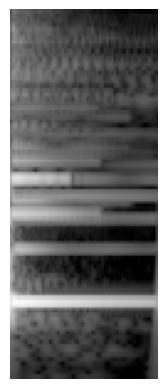

In [ ]:
# Visualize first spectrogram

plt.imshow(X[0], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Save X and y on GCS

save_pkl_to_gcp(X, 'dataset/X')
save_pkl_to_gcp(y, 'dataset/y')

File dataset/X uploaded to GCS.
File dataset/y uploaded to GCS.
